In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784" ,version=1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
mnist.data.shape # features

(70000, 784)

In [8]:
mnist.target.shape # target

(70000,)

In [19]:
mnist.frame.shape # combined

(70000, 785)

In [124]:
X = mnist["data"]
y = mnist["target"]

### Basis EDA

In [139]:
sample_digit = X.iloc[11]

In [140]:
sample_image = sample_digit.values.reshape(28, 28)

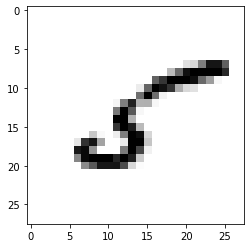

In [141]:
plt.imshow(sample_image, cmap="binary")
# plt.axis("off")
plt.show()

In [142]:
sample_label = y[11]
sample_label

'5'

In [144]:
y = y.astype(np.uint8) # converting string labels to integers

In [145]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

### Implementing binary classifier

In [146]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [147]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [148]:
sgd_clf.predict([sample_digit])

D:\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

#### Performance measures

In [166]:
"""Occasionally you will need more control over the cross-validation 
process than what Scikit-Learn provides off the shelf. 
In these cases, you can implement cross-validation yourself. 
The following code does roughly the same thing as Scikit-Learn’s 
cross_val_score() function, and it prints the same result:"""


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

sk_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in sk_fold.split(X_train, y_train_5):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf = clone(sgd_clf)
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [167]:
from sklearn.model_selection import cross_val_score

clone_clf = clone(sgd_clf)
cross_val_score(clone_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

##### Observations 
    - Here accuracy is about 92% and also higher than it. But unfortunately it is due to more skewed datasets. It hase 90% false(not five) and 10% true(five) values.
    - So accuracy is not preferred performance measure for classifiers specially when we have skewed datasets

#### Confusion Matrix

In [173]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [177]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

##### Observations
    - True Negative: 53892
    - False Positive: 987
    - False Negative: 1891
    - True Positive: 3530
    
    Precision: 
        - measure of accuracy of postive predictions 
        - Equation: TP/TP + FP
    Recall: 
        - measurre of positive instances that are correcly classified
        - Equation: TP/TP + FN

#### Precision and Recall

In [182]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [181]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

##### Observations
    - when it claims an image represents a 5, it is coorect only 83.71% of time and it detects 65.12% of the 5s

#### F1 score

In [183]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

##### Notes
    - The F1 score is hamrmonic mean of precision and recall. Regular mean treats all the values equally, the harmonis mean gives much more weight to low values. As a result, the classifier only get a high F1 score if both recall and precision are high

#### To get classifier score 

In [185]:
y_scores = sgd_clf.decision_function([sample_digit])

D:\TheCompleteML\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [187]:
y_scores

array([4742.52813158])

In [190]:
threshold =  0
(y_scores>threshold)

array([ True])

In [191]:
threshold =  8000
(y_scores>threshold)

array([False])

##### Observations
    - as we increase the threshold recall score will decrease and precision score increases, and vice versa

#### Deciding the threshold?

In [273]:
clone_clf = clone(sgd_clf)

In [274]:
y_scores = cross_val_predict(clone_clf, X_train, y_train_5, cv=3, method="decision_function")

In [275]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [276]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(("Precision", "Recall"))
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.grid()
    plt.show()

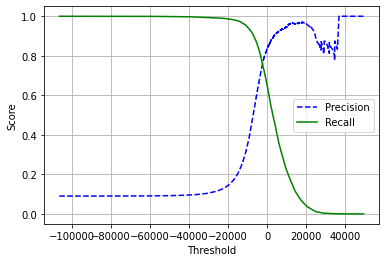

In [277]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [297]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlabel("Recalls")
    plt.ylabel("Precisions")
    plt.grid()
    plt.show()

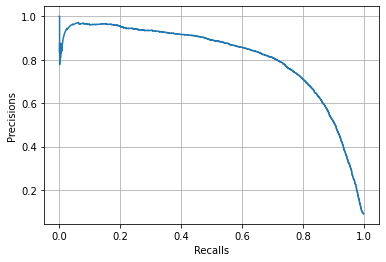

In [298]:
plot_precision_vs_recall(precisions, recalls)

#### To get 90% precision values
    - first we need to get the value of thresholds where precision is just crossing above 90%
    - prediction should be done based on that threshold value rathre then predict method

In [305]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [306]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [307]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [308]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

##### Observations
    - Thus like this we can get whatever precision and recall score.
    - but high precision model with recall is too low can't be used much
    
    Note:
        - If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

#### ROC(Receiver operating characteristic) Curve
    - ROC curve the TPR(True positive rate) againts the FPR(False positive rate)
    - FPR is the ratio negative instances that are incorrectly classified
    - Equation: FPR = 1 - TNR
    - TNR is ratio of negative instances that are correctly classsified. Which is also known as specificity
    - Hence ROC curve plots sensitivity vs 1 - specificity 

In [310]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [319]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.grid()
    plt.show()

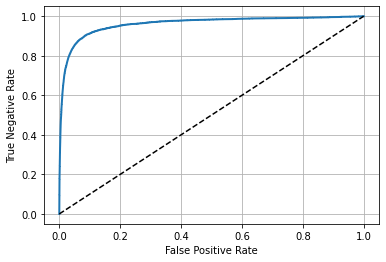

In [320]:
plot_roc_curve(fpr, tpr)

##### Observations
    - Again trade-off here, the higher the TPR lower the FPR
    - The dotted line here represents the ROC curve of purely random cladssifier, a good classifier stays as far away from that line
    
##### Note:
        - One way to compare the classifier is to measure the area under the curve(AUC).
        - Perfect classifier will have a ROC AUC 1, where as random classfier will have ROC AUC value 0.5

In [321]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Note
    - As a rule of thumb, one should prefer the PR curve whenever the positive class is rare or when one care more about the 